In [1]:
from tsai.all import *
computer_setup()

os              : Windows-10-10.0.22621-SP0
python          : 3.9.16
tsai            : 0.3.6
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 1.13.1
device          : 1 gpu (['NVIDIA GeForce RTX 4060 Laptop GPU'])
cpu cores       : 10
threads per cpu : 1
RAM             : 15.8 GB
GPU memory      : [8.0] GB


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
from imblearn.over_sampling import RandomOverSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import math
import numpy as np
import pandas as pd#我一般喜欢用这个读入数据
import os
import csv
from tqdm import tqdm
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [4]:
df = pd.read_csv('./covid.train.csv')
#df.head()
dat=df.drop(['id'],axis=1) 
data = np.array(dat.loc[:,:]) 
df.corr()['tested_positive'].sort_values(ascending=False)
data


array([[ 1.       ,  0.       ,  0.       , ..., 53.9915494, 43.6042293,
        20.7049346],
       [ 1.       ,  0.       ,  0.       , ..., 54.185521 , 42.6657659,
        21.2929114],
       [ 1.       ,  0.       ,  0.       , ..., 53.6370693, 42.972417 ,
        21.1666563],
       ...,
       [ 0.       ,  0.       ,  0.       , ..., 67.731162 , 38.740651 ,
        12.6134414],
       [ 0.       ,  0.       ,  0.       , ..., 67.7950996, 38.595125 ,
        12.4772268],
       [ 0.       ,  0.       ,  0.       , ..., 68.2840782, 38.4538196,
        11.8117187]])

In [5]:
#train_and_test_data = pd.read_csv('./covid.train.csv').values
#train_and_test_data=df.drop([‘id’],axis=1)
Y_ALL=data[:,-1]
X_ALL=data[:,:-1]
total_len = len(data)
split_idx = int(total_len * 0.7)
a=(X_ALL[:,43])
# 获取训练集和测试集
train_data = data[:split_idx]
test_data = data[split_idx:]
y_train=train_data[:,-1]
X_train=train_data[:,:-1]
y_valid=test_data[:,-1]
X_valid=test_data[:,:-1]
splits = get_predefined_splits(X_train, X_valid)


In [5]:
def select_feat(X_train, X_valid, select_all=True):
    '''Selects useful features to perform regression'''
    X_valid=X_valid
    X_train=X_train
     
    if select_all:
        feat_idx = list(range(X_train.shape[1]))
    else:
        feat_idx = list(range(40))+[58,76] # TODO: Select suitable feature columns.
        
    return X_train[:,feat_idx], X_valid[:,feat_idx]

X_train,X_valid=select_feat(X_train, X_valid,select_all=True)
X_ALL=np.concatenate((X_train, X_valid), axis=0)

X      - shape: (2700, 93)  type: ndarray  dtype:float64  isnan: 0
y      - shape: (2700,)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [1889, 811]  overlap: False


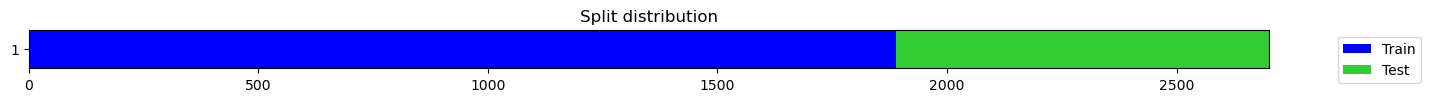

In [6]:
check_data(X_ALL, Y_ALL, splits)

In [7]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dsets = get_ts_dls(X_ALL, Y_ALL, tfms=tfms, splits=splits,batch_tfms=batch_tfms,bs=100)
dsets.one_batch()


(TSTensor(samples:100, vars:1, len:93, device=cuda:0, dtype=torch.float32),
 tensor([12.7806, 14.0370,  6.4376,  5.7635,  4.3846, 12.5554, 15.3061,  9.4370,
          6.2500,  9.5076, 16.3948, 21.5362, 27.9032, 18.2353,  8.3295, 12.8408,
         20.1553, 17.5585,  5.3960, 19.6625,  6.7568, 10.2011, 15.6772, 15.1599,
         28.4617, 15.6231, 12.7403,  6.9672, 23.6040, 16.8981, 17.2330,  8.7530,
          9.3464, 12.1542,  2.8180,  7.8224, 10.3342,  5.3867,  7.4901, 12.6981,
         14.7400,  4.4715, 14.8438, 26.5838, 21.4534, 15.4295, 24.4339,  9.7441,
         20.1652, 16.1607,  6.3151,  3.5552,  9.3069,  3.2285,  6.4413, 28.5692,
          8.4688,  9.5381,  9.7082,  5.5891, 16.6666, 11.0325, 16.7753, 23.7719,
         24.7259,  4.3382,  5.7616, 13.4758,  7.8824,  9.4027, 29.6456, 21.4053,
         25.5589, 15.3364, 21.9274, 21.8326,  7.7938, 19.3056,  5.9165, 27.3015,
         17.8601,  6.0086,  9.3152, 13.0259,  4.7581, 29.4770, 21.7023, 22.8458,
         19.9523, 14.4099, 14.745

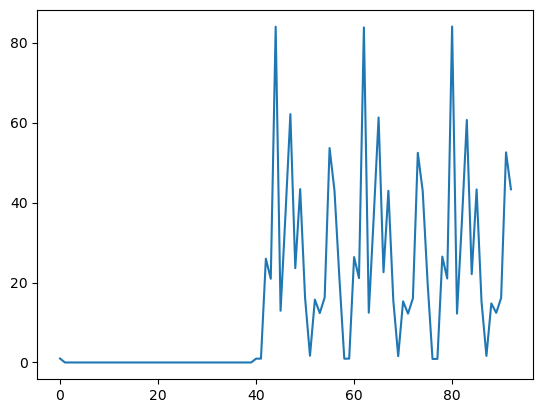

In [8]:
plt.plot(X_ALL[4].T);

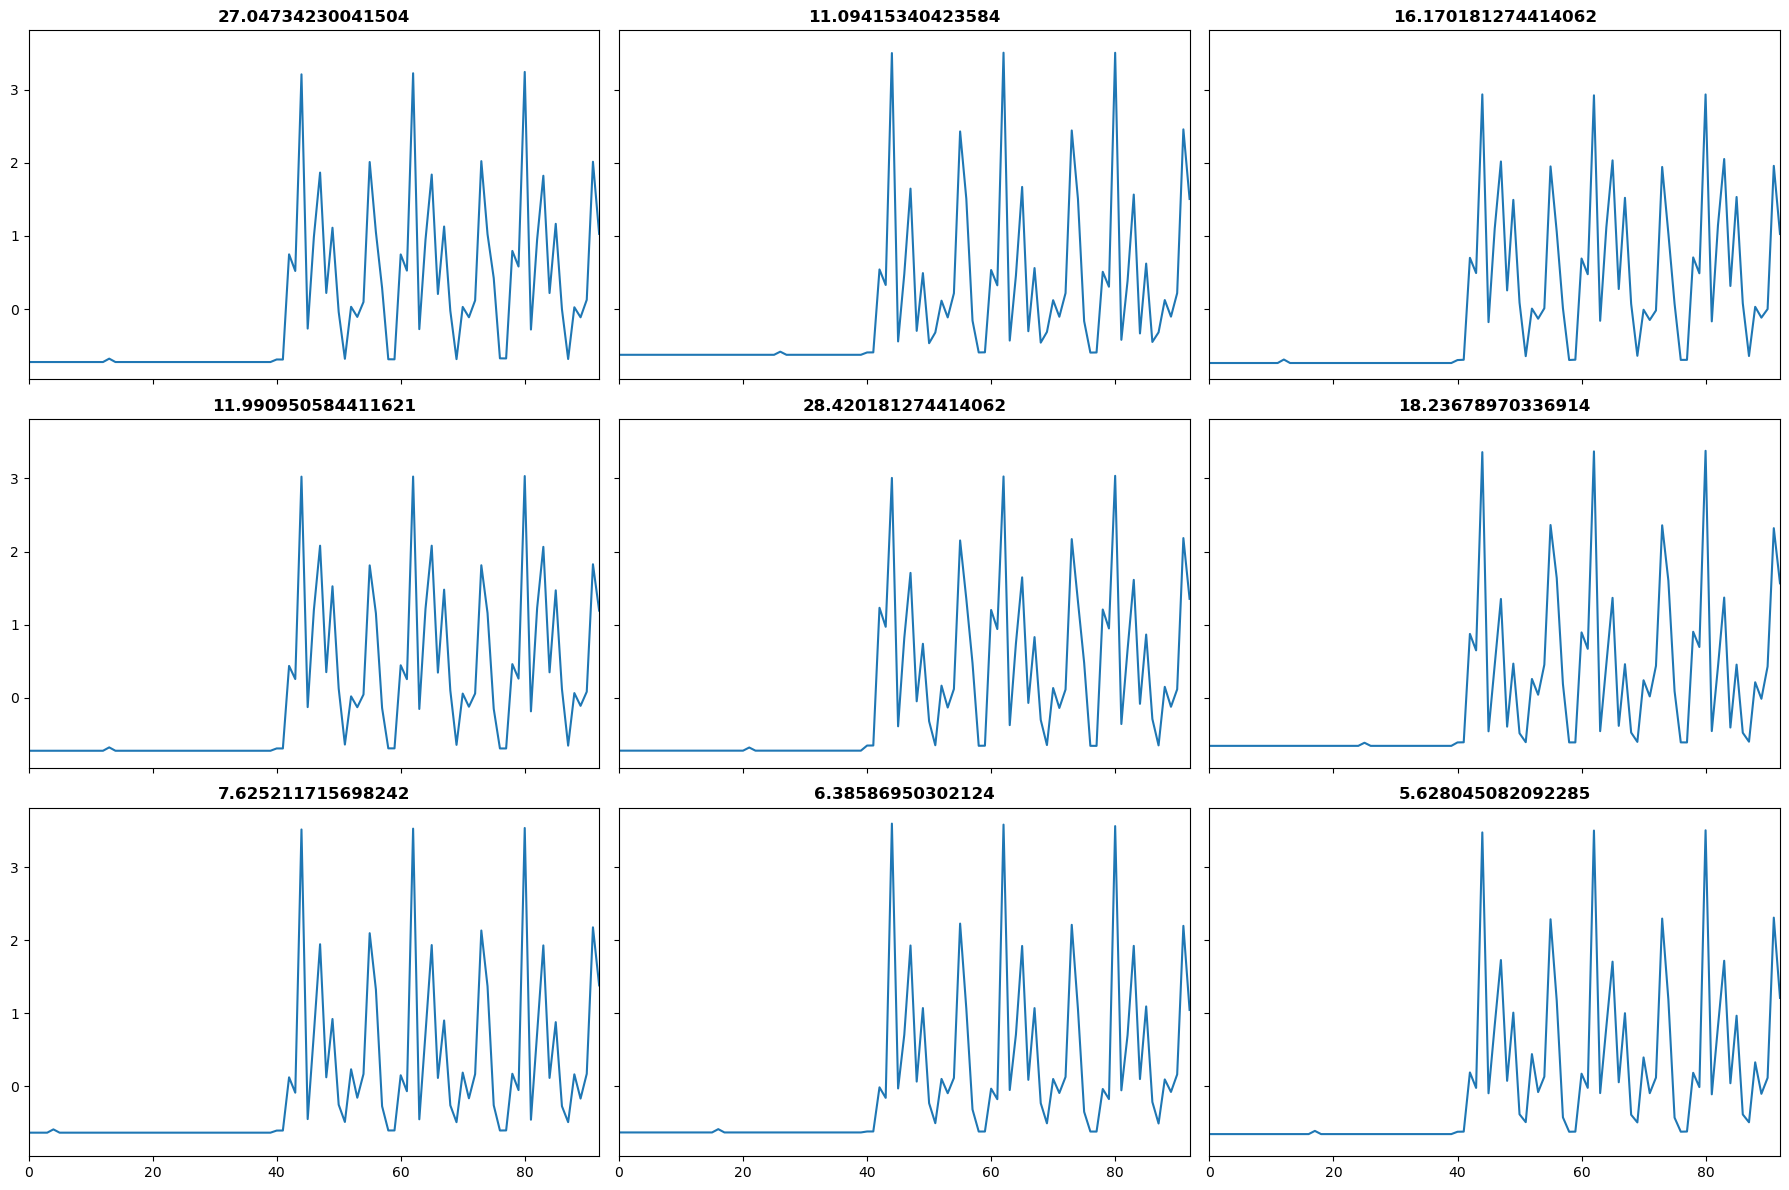

In [9]:
dsets.show_batch(sharey=True)

SuggestedLRs(valley=0.009120108559727669)

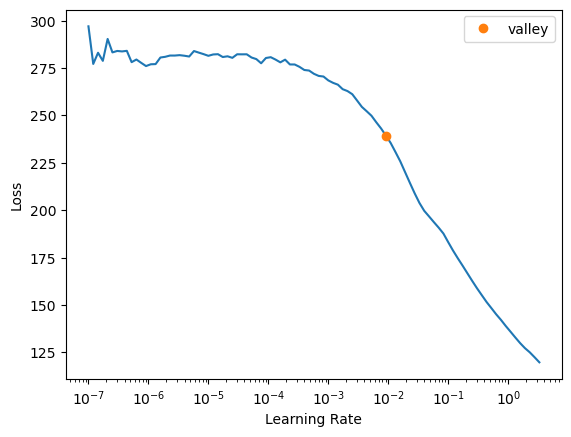

In [10]:
learn = ts_learner(dsets, InceptionTime, metrics=[mae,rmse,mse], cbs=ShowGraph())
learn.lr_find()

In [11]:
learn.loss_func

FlattenedLoss of MSELoss()

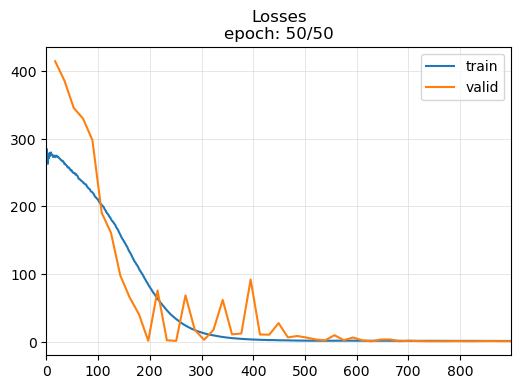

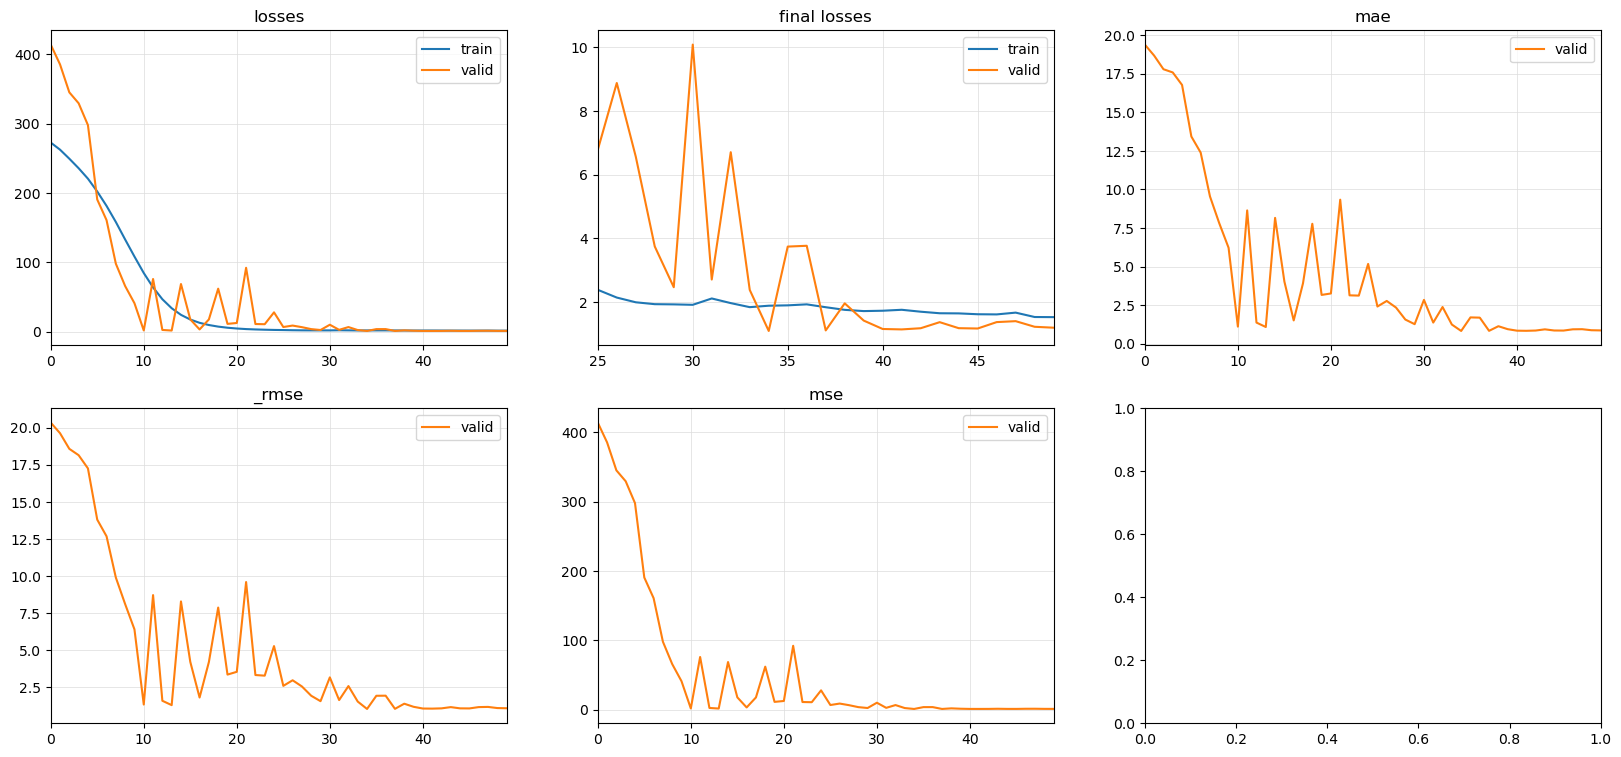

In [12]:

learn.fit_one_cycle(50, 1e-3)

In [13]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

In [14]:
del learn, dsets,

In [15]:
learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:100, vars:1, len:93, device=cuda:0, dtype=torch.float32),
 tensor([22.8746, 23.7527, 23.1402, 23.9115, 25.6969, 25.9811, 26.7078, 25.6844,
         24.6701, 25.4924, 25.3483, 24.5305, 24.7660, 24.8246, 25.6022, 25.7795,
         26.6361, 27.2260, 26.6688, 26.8926, 26.3140, 26.1734, 26.6139, 25.4348,
         24.4875, 25.8145, 25.1279, 24.7070, 24.4859, 24.0851, 23.9214, 24.5663,
         23.6003, 24.5000, 25.0780, 25.7552, 25.7552, 25.9815, 26.3706, 26.8985,
         26.1066, 26.8204, 27.2539, 28.0782, 29.3294, 28.5535, 27.9216, 28.2166,
         26.9071, 26.7993, 26.5958, 25.4401, 25.8577, 25.3007, 24.6485, 25.4667,
         24.0300, 23.4956, 22.8251, 21.5116, 20.9893, 20.5535, 19.7124, 24.8711,
         25.2803, 24.4827, 24.4258, 23.2263, 21.5702, 21.1755, 22.3770, 22.1942,
         23.7068, 21.9658, 23.4949, 23.4348, 25.3534, 24.9680, 26.3721, 26.8387,
         27.9312, 26.6685, 28.5991, 27.6106, 27.0749, 26.4274, 25.5729, 26.5690,
         28.0660, 27.3353, 28.042

In [16]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds


(tensor([[21.1850],
         [22.2386],
         [22.8803],
         [22.2438],
         [23.0097],
         [24.5605],
         [24.7250],
         [25.2971],
         [24.3563],
         [23.5789],
         [24.2381],
         [23.9843],
         [23.2577],
         [23.5133],
         [23.5241],
         [24.2015],
         [24.3483],
         [25.1559],
         [25.6651],
         [25.1821],
         [25.3644],
         [24.8637],
         [24.7698],
         [25.1404],
         [24.1520],
         [23.4725],
         [24.6728],
         [23.8953],
         [23.5029],
         [23.4024],
         [23.1559],
         [23.0455],
         [23.5851],
         [22.6856],
         [23.6576],
         [24.2372],
         [24.8301],
         [24.7971],
         [25.1022],
         [25.3813],
         [25.8353],
         [25.0281],
         [25.5931],
         [25.8610],
         [26.4746],
         [27.2279],
         [26.5533],
         [26.0034],
         [26.2121],
         [25.0584],


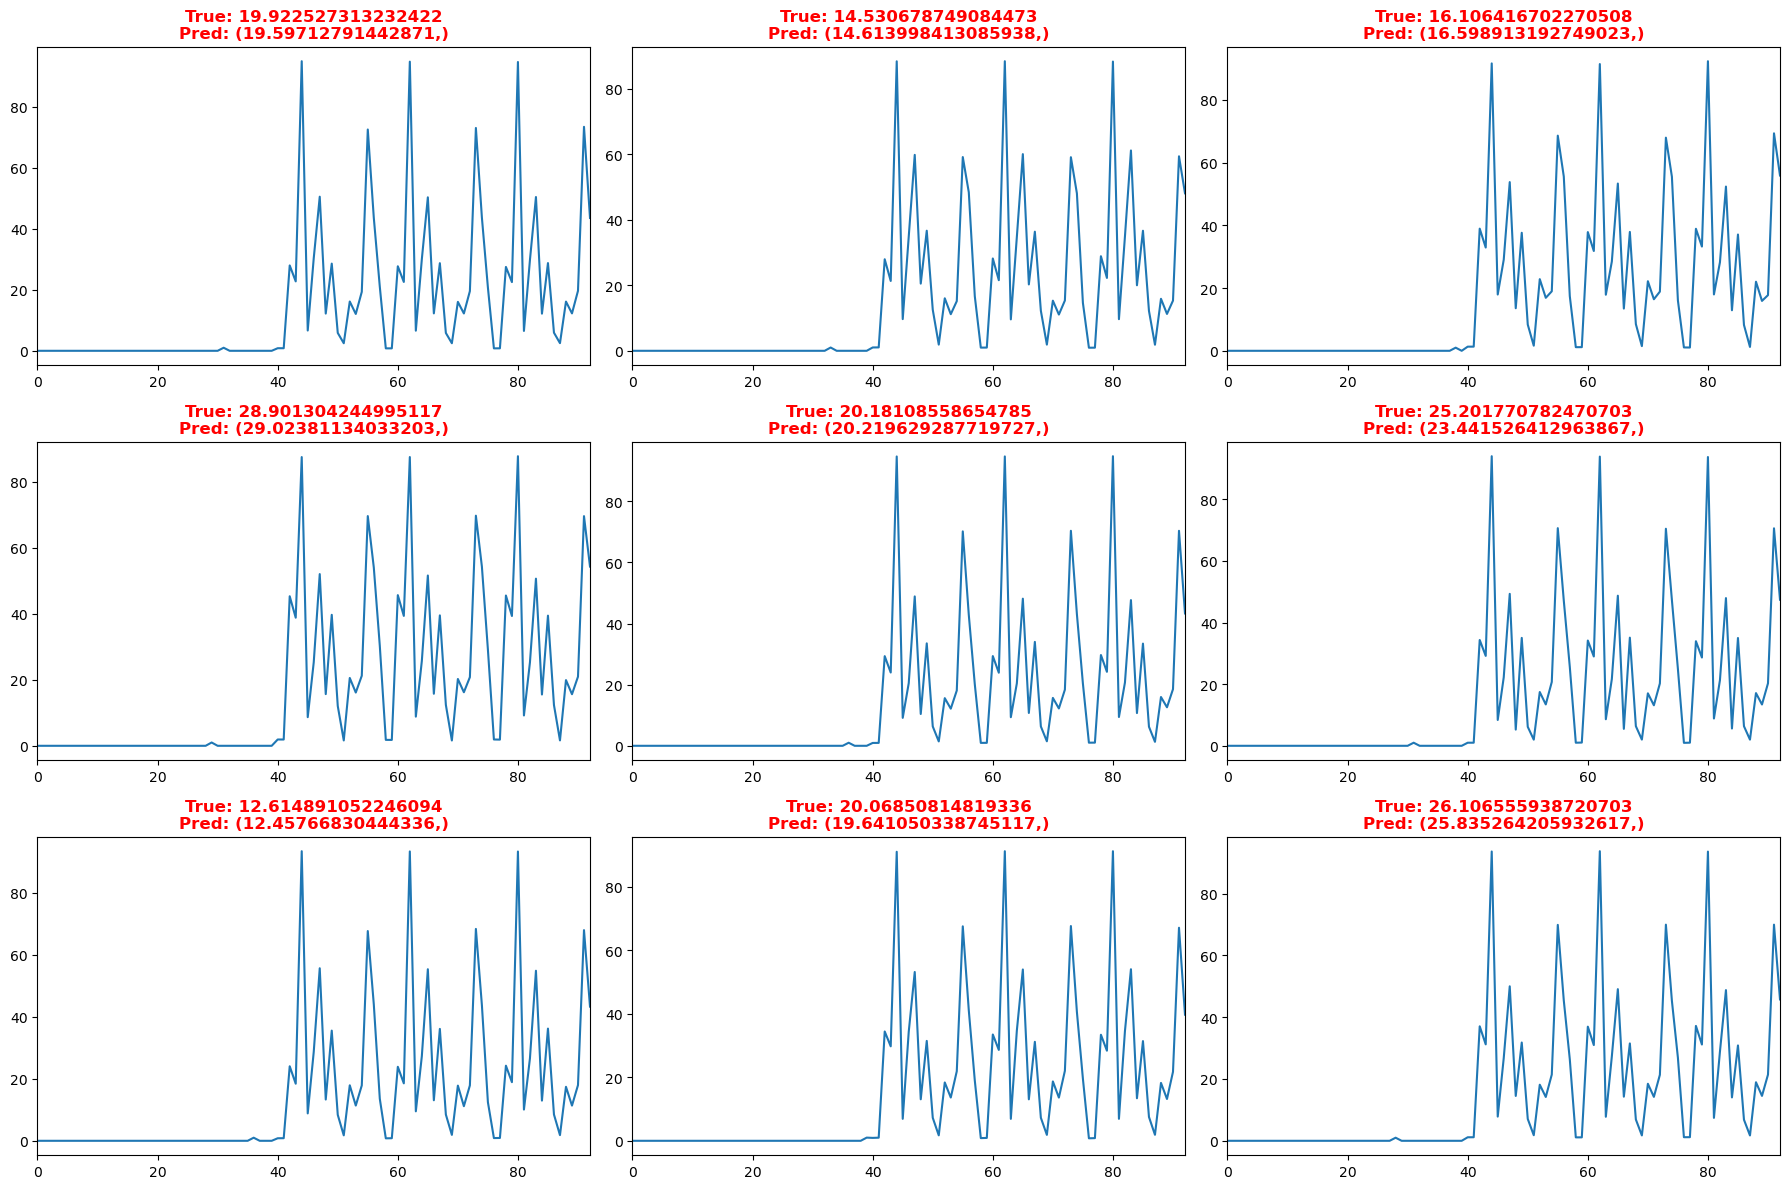

In [17]:
learn.show_results()

In [19]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])
save_pred(valid_preds, 'pred2.csv')